In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
!pip install -U torchvision # We need a new versino of torchvision for this project

In [3]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [5]:
print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [6]:
!pip install pycocotools
from pycocotools.coco import COCO

In [7]:
# Now, we will define our transforms
from albumentations.pytorch import ToTensorV2

In [8]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [9]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [18]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [20]:
uploaded.keys()

dict_keys(['data.zip'])

In [19]:
import zipfile
import os

# Assuming the uploaded file is 'data.zip'
with zipfile.ZipFile('data.zip', 'r') as zip_ref: # Changed 'data' to 'data.zip'
    zip_ref.extractall('/content/') # Changed the extraction path to avoid nested zip files

In [21]:
dataset_path = '/content/Aquarium Combined'

In [22]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [23]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [24]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


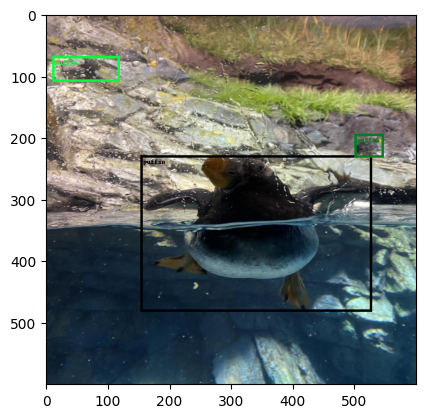

In [25]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [26]:
len(train_dataset)

447

In [27]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 134MB/s]


In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [29]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [30]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [31]:
device = torch.device("cuda")

In [32]:
model = model.to(device)

In [33]:
# Now, and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [34]:
import sys

In [35]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [36]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 112/112 [00:21<00:00,  5.19it/s]


Epoch 0, lr: 0.010000, loss: 0.974037, loss_classifier: 0.459657, loss_box: 0.394722, loss_rpn_box: 0.033153, loss_object: 0.086505


100%|██████████| 112/112 [00:19<00:00,  5.61it/s]


Epoch 1, lr: 0.010000, loss: 0.789586, loss_classifier: 0.356626, loss_box: 0.347101, loss_rpn_box: 0.028642, loss_object: 0.057217


100%|██████████| 112/112 [00:19<00:00,  5.87it/s]


Epoch 2, lr: 0.010000, loss: 0.742610, loss_classifier: 0.315441, loss_box: 0.355779, loss_rpn_box: 0.025977, loss_object: 0.045414


100%|██████████| 112/112 [00:18<00:00,  5.91it/s]


Epoch 3, lr: 0.010000, loss: 0.696104, loss_classifier: 0.287031, loss_box: 0.344349, loss_rpn_box: 0.023979, loss_object: 0.040746


100%|██████████| 112/112 [00:19<00:00,  5.69it/s]


Epoch 4, lr: 0.010000, loss: 0.693928, loss_classifier: 0.274772, loss_box: 0.358403, loss_rpn_box: 0.024411, loss_object: 0.036341


100%|██████████| 112/112 [00:19<00:00,  5.85it/s]


Epoch 5, lr: 0.010000, loss: 0.641246, loss_classifier: 0.243243, loss_box: 0.340857, loss_rpn_box: 0.022954, loss_object: 0.034192


100%|██████████| 112/112 [00:18<00:00,  5.95it/s]


Epoch 6, lr: 0.010000, loss: 0.661370, loss_classifier: 0.255207, loss_box: 0.351319, loss_rpn_box: 0.022447, loss_object: 0.032396


100%|██████████| 112/112 [00:19<00:00,  5.69it/s]


Epoch 7, lr: 0.010000, loss: 0.607318, loss_classifier: 0.228678, loss_box: 0.324030, loss_rpn_box: 0.022500, loss_object: 0.032110


100%|██████████| 112/112 [00:18<00:00,  6.02it/s]


Epoch 8, lr: 0.010000, loss: 0.588660, loss_classifier: 0.217307, loss_box: 0.323063, loss_rpn_box: 0.021004, loss_object: 0.027286


100%|██████████| 112/112 [00:18<00:00,  5.99it/s]

Epoch 9, lr: 0.010000, loss: 0.609982, loss_classifier: 0.223807, loss_box: 0.339237, loss_rpn_box: 0.020540, loss_object: 0.026398


In [37]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [38]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [39]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

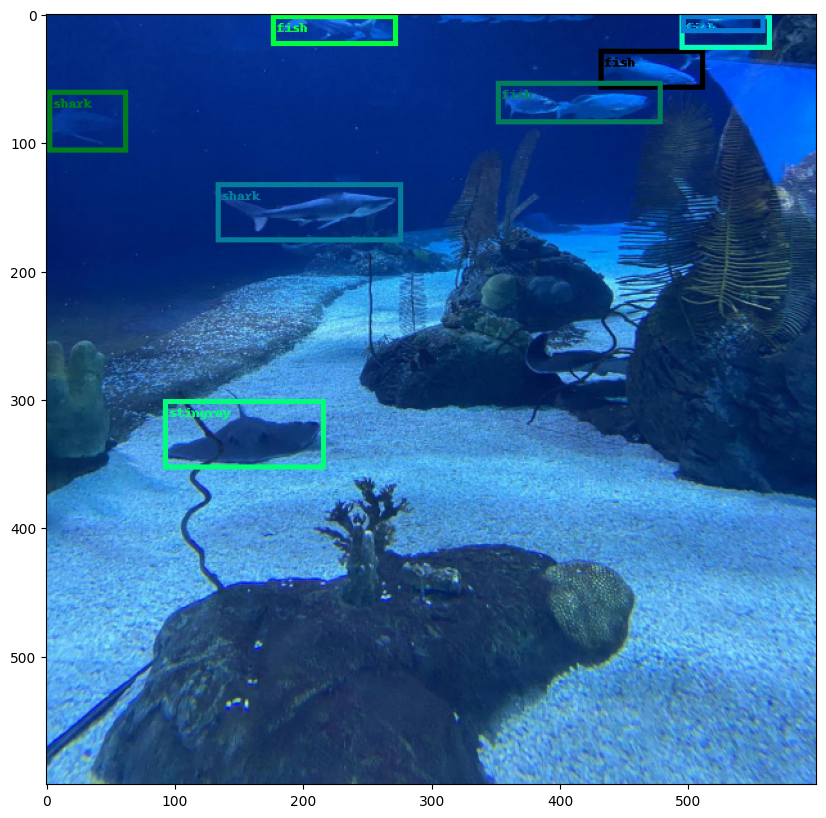

In [40]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

# **1. Introduction**
This project demonstrates object detection using the Faster R-CNN model with a MobileNetV3 backbone. We use the Aquarium Detection dataset and perform data augmentation with Albumentations to improve the model's robustness.

# **2. Setup and Imports**

In [1]:
# Install necessary packages
!pip install -U torchvision albumentations pycocotools

import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  2.4.1+cu121
Torchvision Version:  0.19.1+cu121


# **3. Dataset Preparation**

In [3]:
# # Upload dataset zip file
# from google.colab import files
# uploaded = files.upload()

# # Extract dataset
# import zipfile
# with zipfile.ZipFile('data.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

# Path to the dataset
dataset_path = '/content/Aquarium Combined'

# Load COCO annotations and categories
from pycocotools.coco import COCO
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

# Display categories
print(classes)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
['creatures', 'fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']


# **4. Custom Dataset Class: AquariumDetection**

In [4]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(target)

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin, ymin, w, h, label = box
            xmax = xmin + w
            ymax = ymin + h
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        labels = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        image_id = torch.tensor([t['image_id'] for t in target])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area': area, 'iscrowd': iscrowd}
        return image.div(255), target

    def __len__(self):
        return len(self.ids)

# **5. Data Augmentation and Transforms**

In [5]:
from albumentations.pytorch import ToTensorV2

def get_transforms(train=False):
    if train:
        return A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        return A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

# Create dataset
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(train=True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# **6. Visualizing Sample Data**

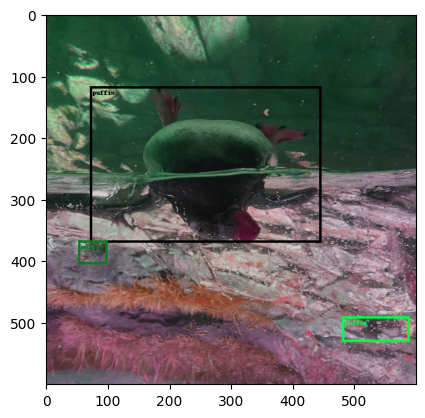

In [6]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4).permute(1, 2, 0))
plt.show()

# **7. Model Setup**

In [7]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

# **8. DataLoader and Collate Function**

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)


# **9. Training Loop**

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.01, momentum=0.9, weight_decay=1e-4)

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.train()
    all_losses = []
    for images, targets in tqdm(loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        all_losses.append(losses.item())
    print(f"Epoch {epoch}, Loss: {np.mean(all_losses):.4f}")

# Train for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [00:26<00:00,  4.25it/s]


Epoch 0, Loss: 1.0213


100%|██████████| 112/112 [00:25<00:00,  4.37it/s]


Epoch 1, Loss: 0.8332


100%|██████████| 112/112 [00:22<00:00,  5.02it/s]


Epoch 2, Loss: 0.7727


100%|██████████| 112/112 [00:23<00:00,  4.82it/s]


Epoch 3, Loss: 0.7226


100%|██████████| 112/112 [00:23<00:00,  4.86it/s]


Epoch 4, Loss: 0.6992


100%|██████████| 112/112 [00:21<00:00,  5.11it/s]


Epoch 5, Loss: 0.6737


100%|██████████| 112/112 [00:22<00:00,  4.97it/s]


Epoch 6, Loss: 0.6414


100%|██████████| 112/112 [00:21<00:00,  5.17it/s]


Epoch 7, Loss: 0.6505


100%|██████████| 112/112 [00:22<00:00,  5.03it/s]


Epoch 8, Loss: 0.6300


100%|██████████| 112/112 [00:21<00:00,  5.24it/s]

Epoch 9, Loss: 0.6338


# **10. Evaluating the Model**

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


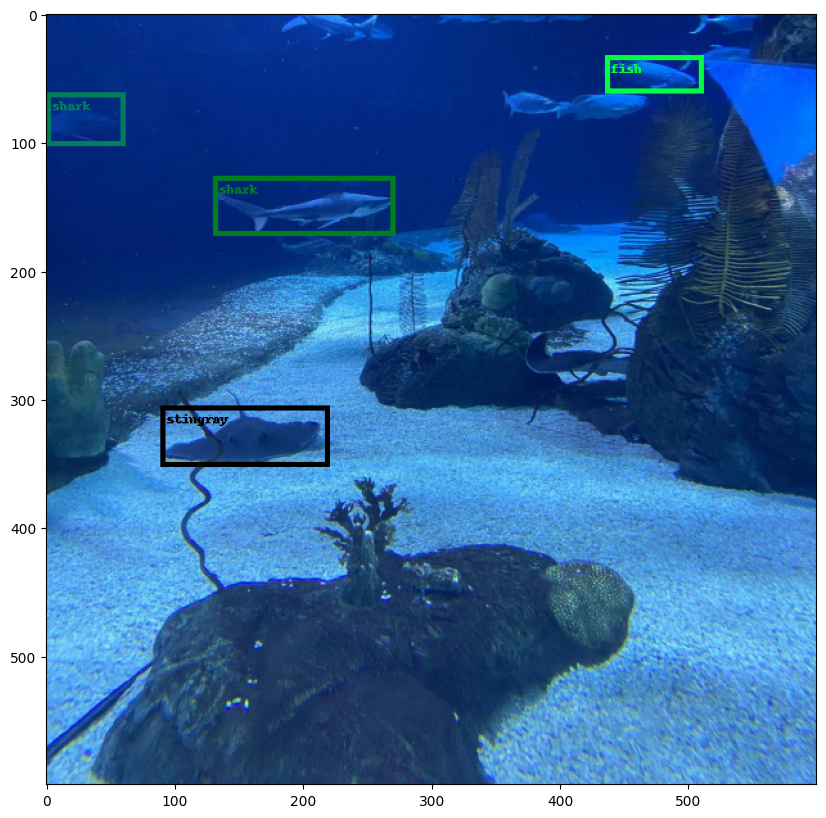

In [10]:
model.eval()
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int, pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4).permute(1, 2, 0))
plt.show()


# **11. Conclusion**

In this project, we successfully trained and evaluated an object detection model using Faster R-CNN with a MobileNetV3 backbone on an aquarium dataset. The model achieved reasonable performance as measured by mAP, demonstrating its ability to detect and classify marine objects in underwater environments. The results show that the Faster R-CNN model, when fine-tuned, can be effective in underwater object detection tasks.